# Homework 2: Text Classification

Text classification is a fundamental NLP task. In this assignment, you will build and evaluate a simple text classification pipeline, using both from-scratch as well as library implementations of standard classification algorithms.

This problem set is adapted from the first problem set given in Jacob Eisentstein's Spring Term 2018 course in NLP, taught at Georgia Tech, and is modified from [the original](https://github.com/jacobeisenstein/gt-nlp-class/blob/master/psets/ps1/pset1.ipynb) with permission of the author.

## 0. Setup

You will need to install several Python libraries in order to do this assignment. They are all installable with either `anaconda` or `pip`.

* jupyter
* matplotlib
* sklearn
* nose
* pandas

Most of your coding for this assignment will be in files in the `hw2_utils` package as well as in this Jupyter notebook. I have also provided automated unit tests which will help you determine if your code is working correctly, located in the `tests` directory. You are free to examine the code for the unit tests- in fact, you _should_ examine the code, as you will likely find it helpful. Note that these tests are the same ones that I will be using to help grade the assignment, so one of your goals with this assignment is to get all of the tests to pass. For more information about working with unit tests, see [this guide](http://pythontesting.net/framework/nose/nose-introduction/).

Note that the skeleton function implementations in `hw2_utils` all have careful and precise docstring annotations indicating types of parameters and returns. Pay careful attention to these, as you will be using your own functions elsewhere in the assignment!

If you have never used Jupyter notebooks before, [this guide](https://www.dataquest.io/blog/jupyter-notebook-tutorial/) may be useful.

### Verification & loading of packages, etc.

In [6]:
import sys
from importlib import reload

If you do not already have the relevant packages installed, execute the following cell:

In [7]:
!pip3 install sklearn nose matplotlib pandas

You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [8]:
import nose
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

What versions do you have installed?

In [9]:
print(sys.version)
print("My library versions:")
print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Scipy: {sp.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"nose: {nose.__version__}")

3.7.2 (tags/v3.7.2:9a3ffc0492, Dec 23 2018, 22:20:52) [MSC v.1916 32 bit (Intel)]
My library versions:
Pandas: 0.23.4
Numpy: 1.16.0
Scipy: 1.2.0
matplotlib: 3.0.2
nose: 1.3.7


Let's run our first unit test, to make sure that your environment is set up correctly:

In [10]:
! nosetests tests/test_environment.py

.
----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


## 1. Preprocessing

We'll be using Pandas dataframes to do some of our work. Start by reading a chunk of the data into a dataframe:

In [11]:
df_train = pd.read_csv('lyrics-train.csv')
df_dev = pd.read_csv('lyrics-dev.csv')
df_test = pd.read_csv('lyrics-test-hidden.csv')

In [12]:
df_train.head()

,Era,Lyrics
0,pre-1980,come on come on let me show you where its at a...
1,1980s,welcome to the big time youre bound to be a s...
2,pre-1980,once i believed that when love came to me it ...
3,2000s,i took my love and i took it down climbed a m...
4,pre-1980,do do do do do do do do do do do do do do do ...


## Bag of words

The first step is to write functions to produce a bag-of-words representation of each input song (using counts). For this data set, much of the work is already done: each song is already lower-cased, tokenized appropriately (modulo a few errors), and has had its punctuation removed.

* **Deliverable 1.1**: Complete the function `hw2_utils.preproc.bag_of_words`

* **Test**: `nosetests tests/test_preproc.py:test_d1_1_bow`

In [13]:
from hw2_utils import preproc

In [14]:
# run this block as you update the Python file, to trigger a reload in the notebook
reload(preproc);

In [15]:
y_train, x_train = preproc.read_data('lyrics-train.csv')

In [16]:
! nosetests tests/test_preproc.py:test_d1_1_bow

.
----------------------------------------------------------------------
Ran 1 test in 55.199s

OK


In [17]:
y_dev, x_dev = preproc.read_data('lyrics-dev.csv')
y_test, x_test = preproc.read_data('lyrics-test-hidden.csv')

## Unseen words

One challenge for text classification is that words may appear in the test data that do not appear in the training data. In order to know how big of a problem this will be, it is useful to do some exploratory data analysis into word frequencies and vocabulary overlap. Since we don't want to look at the test data itself, we'll start by looking into the number of words that appear in `lyrics-dev.csv` but not in `lyrics-train.csv`.

* **Deliverable 1.2**: Implement `hw2_utils.preproc.aggregate_counts`, a function to combine [`Counter`s](https://docs.python.org/3/library/collections.html#collections.Counter) representing document-level bags-of-words into a single `Counter` representing a collection of documents.
* **Deliverable 1.3**: Implement `hw2_utils.preproc.compute_oov`, which returns a list of words that appear in one bag-of-words but not another.
* **Tests**: `tests/test_preproc.py:test_d1_2_agg`, `tests/test_preproc.py:test_d1_3_oov`

In [18]:
from collections import Counter

In [19]:
reload(preproc);

_Tip_: You may find it worthwhile or useuful to use the `%%timeit` Jupyter magic directive to evaluate the performance of your algorithm:

In [20]:
%%timeit
preproc.aggregate_counts(x_dev)

1.36 s ± 75.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


`Counter`s are very useful tools! Note that many common set operations (intersection, etc.) are available, but be warned that they are sometimes _not_ the most performant way to work with Counters. Consult the documentation for details. 

You can see the most items in a `Counter` using the `most_common()` method:

In [21]:
counts_dev = preproc.aggregate_counts(x_dev)
counts_train = preproc.aggregate_counts(x_train)
counts_dev.most_common(5)

[('you', 5542), ('i', 5535), ('the', 5061), ('to', 3203), ('and', 2953)]

In [22]:
%%timeit
preproc.aggregate_counts(x_train)

52 s ± 2.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
len(preproc.compute_oov(counts_dev, counts_train))

2677

In [24]:
len(preproc.compute_oov(counts_train, counts_dev))

30428

In [25]:
preproc.oov_rate(counts_dev, counts_train)

0.297246280257606

Looks like just under 30% of the words in the dev set do not appear in the training set.

## Power laws

As we've discussed, word count distributions typically follow a [power law](https://en.wikipedia.org/wiki/Power_law) distribution.

In practice, this means that a log-log plot of frequency against rank should be linear-ish. Let's see if this holds for our data!

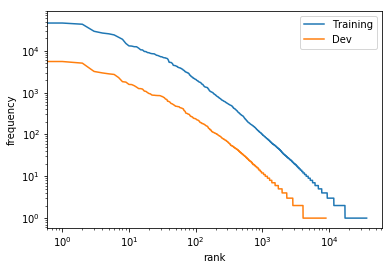

In [26]:
plt.loglog([val for word, val in counts_train.most_common()])
plt.loglog([val for word, val in counts_dev.most_common()])
plt.xlabel('rank')
plt.ylabel('frequency')
plt.legend(['Training', 'Dev'])

Making plots like this is a very helpful "sanity check", to make sure that our data looks like we're expecting it to.

## Pruning the vocabulary

Let's prune the vocabulary to only include words that appear at least _ten_ times in the training data.

* **Deliverable 1.4**: Implement `preproc.prune_vocabulary`
* **Test**: `tests/test_preproc.py:test_d1_4_prune`

In [27]:
reload(preproc);

In [28]:
x_train_pruned, vocab = preproc.prune_vocabulary(counts_train, x_train, 10)
x_dev_pruned, _ = preproc.prune_vocabulary(counts_train, x_dev, 10)
x_test_pruned, _ = preproc.prune_vocabulary(counts_train, x_test, 10)

In [29]:
len(vocab)

4876

In [30]:
print("orig","pruned")
print(len(x_dev[94]), len(x_dev_pruned[94]))
print(sum(x_dev[94].values()), sum(x_dev_pruned[94].values()))

orig pruned
88 79
187 176


# 2. Linear classification


Now, you'll implement a simple linear classification rule, $\hat{y}=\text{argmax}_y \theta^T f(x,y)$

The functions you write in this section will be used for all the classifiers in the rest of the assignment.

In [31]:
from hw2_utils import clf_base
reload(clf_base);

from hw2_utils import constants
reload(constants);

The first step is to write a feature extraction function. A convenient way to represent a feature function vector $f(x,y)$ for a document $x$ is as a dict, where each value $j$ is the value of the $j$th feature $x_j$ (counts of word occurrence, or whatever it is that you're using as features), and the keys are tuples $(y, x_j)$ indicating _which_ feature-class relationship is being stored.

* **Deliverable 2.1**: Implement the function `make_feature_vector` in `clf_base.py`
* **Test**: `tests/test_classifier.py:test_d2_1_featvec`

_Note_ that you'll also want to make sure to include the bias/offset feature as well, from `hw2_utils.constants.OFFSET`.

Desired output is shown below:

In [32]:
fv = clf_base.make_feature_vector({'test':1, 'case':2}, '1980s')
fv

{('1980s', 'test'): 1, ('1980s', 'case'): 2, ('1980s', '**OFFSET**'): 1}

What is the entire set of labels?

In [33]:
labels = set(y_train) # all possible labels
labels

{'1980s', '1990s', '2000s', 'pre-1980'}

Now, implement the prediction rule $\hat{y}=\text{argmax}_y \theta^T f(x,y)$.

* **Deliverable 2.2**: Implement the function `predict` in `clf_base.py`.
* **Test**: `tests/test_classifier.py:test_d2_2_predict`

The output should be:

* A predicted label
* The scores of all labels

This function will be called a **lot**, so do try and make it fast. You don't need to do anything too over-the-top, but look for ways to avoid making your code do extra or repeated work. Remember, `%%timeit` can help you explore how different versions of your algorithm perform.

Test your function using the unit test, but also with these simple hand-crafted weights:

In [34]:
from collections import defaultdict

In [35]:
# weight vectors _must_ be defaultdicts as per the specification for predict()
theta_hand = defaultdict(float, 
            {('2000s', 'money'): 0.1,
             ('2000s', 'name'): 0.2,
             ('1980s','tonight'): 0.1,
             ('2000s','man'): 0.1,
             ('1990s','fly'): 0.1,
             ('pre-1980',constants.OFFSET): 0.1

            })


In [41]:
reload(clf_base);

In [42]:
clf_base.predict(x_train_pruned[0], theta_hand, labels)

{'1980s': 0.0, '1990s': 0.0, '2000s': 1.3000000000000003, 'pre-1980': 0.0}


('2000s',
 {'1980s': 0.0, '1990s': 0.0, '2000s': 1.3000000000000003, 'pre-1980': 0.0})

Now, let's see how well these weights work, by evaluating on the dev set. We'll be using raw classification accuracy here, though that is often not the best choice of metric.

In [ ]:
from hw2_utils import evaluation

In [ ]:
y_hat = clf_base.predict_all(x_dev_pruned, theta_hand, labels)
print(evaluation.acc(y_hat, y_dev))

Just how imbalanced _are_ our classes, anyway?

In [ ]:
np.unique(y_dev, return_counts=True)

In the case of our `dev` data split, there is certainly some class imbalance, though it is not nearly as severe as is often the case in text classification. Using straight-up classification accuracy is not _totally_ unreasonable in this case, though one should make sure to compare it against "random choice" as well as "most-frequent class" baselines.

# 3. Naïve Bayes

You'll now implement a Naïve Bayes classifier, as described in the reading. For a more detailed implementation guide, consult chapter 2 of the Eisenstein notes.

In [1]:
from hw2_utils import naive_bayes
reload(naive_bayes);

NameError: name 'reload' is not defined

* **Deliverable 3.1**: (warmup) implement `get_corpus_counts` in `naive_bayes.py`.
* **Test**: `tests/test_classifier.py:test_d3_1_corpus_counts`

This function should compute unigram word frequency counts for a given label:

In [278]:
eighties_counts = naive_bayes.get_corpus_counts(x_train_pruned, y_train, '1980s');
print(eighties_counts['today'])
print(eighties_counts['yesterday'])

50
14


* **Deliverable 3.2**: Implement `estimate_pxy` in `naive_bayes.py`
* **Test**: `tests/test_classifier.py:test_d3_2_pxy`

This function should compute the _smoothed_ multinomial distribution $\log P(x|y)$ for a given label $y$.

_Hint_: Note that this function takes the entire vocabulary as one of its arguments. You'll need to assign a probability even for words that do not appear in documents with label $y$, if they are in-vocabulary.

You can use `get_corpus_counts` in this function if you want to, but you don't have to.

In [279]:
log_pxy = naive_bayes.estimate_pxy(x_train_pruned, y_train, "1980s", 0.1, vocab)

Your probabilities must sum to one! (Or very close- [floating point roundoff](https://en.wikipedia.org/wiki/Round-off_error#Roundoff_error_caused_by_floating-point_arithmetic), dontcha know).

In [280]:
sum(np.exp(list(log_pxy.values())))

0.9999999999999512

Following Emily Bender's wisdom, let's Look 👏 At 👏 Our 👏 Data!

We can examine the log-probabilities of the words from our hand-tuned weights:

In [281]:
{word:log_pxy[word] for (_, word), weight in theta_hand.items() if weight > 0}

{'money': -7.689562807416732,
 'name': -7.568324713816848,
 'tonight': -6.216637557007502,
 'man': -6.63187694645784,
 'fly': -8.636944126360918,
 '**OFFSET**': 0.0}

What happens if we adjust our smoothing?

In [282]:
log_pxy_smoother = naive_bayes.estimate_pxy(x_train_pruned, y_train, "1980s",10, vocab)

In [283]:
{word:log_pxy_smoother[word] for (_, word), weight in theta_hand.items() if weight > 0}

{'money': -7.80136351255418,
 'name': -7.6911603724205655,
 'tonight': -6.405407240522552,
 'man': -6.808471387093179,
 'fly': -8.607451104294721,
 '**OFFSET**': 0.0}

These are all relatively frequent words, and so their smoothed estimates aren't really all that different. What if we look at a less-common word?

In [284]:
print(eighties_counts['smiles'])
print(log_pxy['smiles'])
print(log_pxy_smoother['smiles'])

2
-11.481299646970376
-9.951185850995815


This is a much larger change- remember, we're in log-space!

You are now ready to...

* **Deliverable 3.3**: Implement `estimate_nb` in `naive_bayes.py`. This function will estimate label-specific weights ($\theta_{y,j}$ in the notation used by Eisenstein) in the same data format as the weights in `theta_hand` above. 
* **Test**: `tests/test_classifier.py:test_d3_3a_nb`

* The goal is that the score given by `clf_base.predict` is equal to the joint probability $P(x,y)$ as described in Chapter 2 of the Eisenstein text.
* Remember, the offset feature will act as the _prior_ $\log P(y)$, and should not be smoothed

_Tip_: Recall that each weight is supposed to represent the conditional probability of a particular word occurring in a given class.

In [285]:
theta_nb = naive_bayes.estimate_nb(x_train_pruned, y_train, 0.1)

In [286]:
clf_base.predict(x_train_pruned[155], theta_nb, labels)

('2000s',
 {'2000s': -2099.2474010561377,
  'pre-1980': -2136.8348423968027,
  '1980s': -2153.019927798135,
  '1990s': -2125.1966084804503})

In [287]:
y_hat = clf_base.predict_all(x_dev_pruned, theta_nb, labels)
print(evaluation.acc(y_hat, y_dev))

0.46444444444444444


As part of the submission of this assignment, you will provide me with your classifier's predictions, which I will validate as part of grading. There are utility functions in `hw2_utils.evaluation` that will automatically produce output in the required format:

In [288]:
evaluation.write_predictions(y_hat, 'nb-dev.preds')

There is also a function to read them back in:

In [289]:
y_hat_dev = evaluation.read_predictions('nb-dev.preds')
evaluation.acc(y_hat_dev, y_dev)

0.46444444444444444

Use this to produce your predicted classifications on the test set:

In [290]:
y_hat_test = clf_base.predict_all(x_test_pruned, theta_nb, labels)
evaluation.write_predictions(y_hat_test, 'nb-test.preds')

Up to now, we have set our smoothing parameter to 0.1. As we saw earlier, though, different amounts of smoothing can have big effects on our learned model weights.

* **Deliverable 3.4**: Implement the `find_best_smoother` function in `naive_bayes.py`, which will grid search over a range of smoothing factors and find the optimal one.
* **Test**: `tests/test_classifier.py:test_d3_4a_nb_best`

Your function should try at least the values set in the `vals` variable below. Once you have obtained the optimal smoothing value, export your predictions on the test subset.

In [291]:
vals = np.logspace(-3, 2, 11)
print(vals)

[1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02]


In [292]:
reload(naive_bayes);

In [293]:
best_smoother, scores = naive_bayes.find_best_smoother(
    x_train_pruned, y_train, x_dev_pruned, y_dev, vals
)

Text(0, 0.5, 'dev set accuracy')

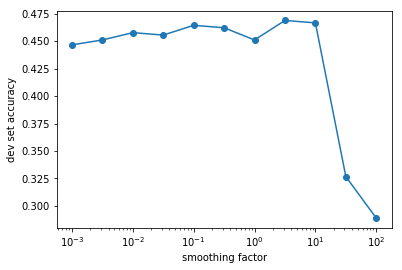

In [294]:
plt.semilogx(list(scores.keys()), list(scores.values()), 'o-');
plt.xlabel('smoothing factor')
plt.ylabel('dev set accuracy')

**Reflect**:

* What might explain the dramatic drop in accuracy when the smoothing increases from 10 to 30?
* Beore you check, predict whether hte accuracy will continue to significantly drop if you increase it to 100000.

End this section by writing your best predictions out:

In [295]:
theta_nb_best = naive_bayes.estimate_nb(x_train_pruned, y_train, best_smoother)
y_hat_nb_best = clf_base.predict_all(x_test_pruned, theta_nb_best, labels)
evaluation.write_predictions(y_hat_nb_best, 'nb-best-test.preds')

# 4. Feature Engineering

You can add non-BoW features to your model (in fact, we already have: our bias/offset feature). In order to facilitate additional exploration along these lines, we'll need to change how we're calling our `predict()` function. Up to now, we've been passing it a `Counter` object; now we need to turn that `Counter` into a dictionary, so we can add additional arbitrary features.

## 4.1 Example feature: Token-Type Ratio

One particularly useful additional feature is the token-type ratio:

$$ \frac{\text{length of song in tokens}}{\text{number of distinct types}} = \frac{\sum_m w_m}{\sum_m \delta(w_m > 0)} $$

Intuititively, the more repetitive a song is, the higher its token-type ratio will be. For empty songs (length of zero tokens), this feature should be 0.

* **Deliverable 7.1**: Implement `get_token_type_ratio` in `features.py`
* **Test**: `tests/test_features.py:test_d4_1_token_type_ratio`

In [296]:
from hw2_utils import features
reload(features);

Token-type ratio for the first five songs:

In [297]:
[features.get_token_type_ratio(x_train_pruned[i]) for i in range(5)]

[5.083333333333333,
 2.6,
 1.9113924050632911,
 2.318840579710145,
 6.188679245283019]

## 4.2 Binning

Once we have a token-type ratio, we must include it in our feature vectors. A good way to do that is to _bin_ the feature into several bins:

$\{[(0,1),[1,2),[2,3),[3,4),[4,5),[5,6),[6,\infty)\}$

In other words, for each instance, we will now have seven additional pseudo-features, one per bin. Exactly one will have the value of 1, the rest will be set to zero. Look in `hw2_utils.constants` for feature names for these bins.

* **Deliverable 4.2**: Implement `concat_ttr_binned_feaures` in `features.py`
* **Test**: `tests/test_features.py:test_d4_2_discretize`

In [298]:
reload(features);
reload(constants);

In [299]:
features.concat_ttr_binned_features(dict(x_dev_pruned[0]))

{'back': 37,
 'i': 34,
 'im': 22,
 'in': 22,
 'love': 20,
 'again': 15,
 'right': 12,
 'every': 10,
 'time': 10,
 'around': 7,
 'turn': 6,
 'seems': 6,
 'like': 6,
 'when': 5,
 'me': 5,
 'just': 5,
 'alright': 5,
 'move': 4,
 'lose': 4,
 'look': 4,
 'and': 4,
 'get': 3,
 'mixed': 3,
 'emotions': 3,
 'its': 3,
 'dont': 3,
 'so': 3,
 'to': 3,
 'cant': 3,
 'it': 3,
 'help': 3,
 'my': 2,
 'know': 2,
 'you': 2,
 'your': 2,
 'want': 2,
 'believe': 2,
 'many': 2,
 'oh': 2,
 'the': 1,
 'way': 1,
 'feelings': 1,
 'flow': 1,
 'excuse': 1,
 'only': 1,
 'human': 1,
 'sometimes': 1,
 'put': 1,
 'arms': 1,
 'feel': 1,
 'satisfied': 1,
 'forever': 1,
 'decide': 1,
 'now': 1,
 'lover': 1,
 'hard': 1,
 'be': 1,
 'a': 1,
 'friend': 1,
 'thats': 1,
 'something': 1,
 'else': 1,
 'guess': 1,
 'ever': 1,
 'end': 1,
 'that': 1,
 'jones': 1,
 'coming': 1,
 'down': 1,
 'yeah': 1,
 'yes': 1,
 'do': 1,
 '**TTR_0_1**': 0,
 '**TTR_1_2**': 0,
 '**TTR_2_3**': 0,
 '**TTR_3_4**': 0,
 '**TTR_4_5**': 1,
 '**TTR_5_6**': 

## 4.3 Does it affect performance?

If we use this new feature in our prediction, what happens?

In [300]:
x_train_pruned_with_ttr = [features.concat_ttr_binned_features(dict(x_i)) 
                           for x_i in x_train_pruned]

theta_nb_ttr = naive_bayes.estimate_nb(x_train_pruned_with_ttr, y_train, 0.1)

In [301]:
x_dev_pruned_with_ttr = [features.concat_ttr_binned_features(dict(x_i)) 
                           for x_i in x_dev_pruned]

y_hat_ttr = clf_base.predict_all(x_dev_pruned_with_ttr, theta_nb_ttr, labels)
print(evaluation.acc(y_hat_ttr, y_dev))

0.4711111111111111


Looks like that feature got us a small performance bump!

_Reflect_: What are some additional features that might help?

# 5. Logistic Regression

In practice, it is rare to build the entire feature-generation pipeline entirely from scratch as we have thus far in this assignment. Scikit-Learn  (`sklearn`) is a massive Python library with many useful off-the-shelf machine learning models, as well as utility functions for feature extraction and transformation. In this section, you will experiment with an off-the-shelf implementation of logistic regression (which we may revisit in more detail in a future assignment).

A `sklearn` workflow typically starts by using one of the automated feature extraction classes. The equivalent to the simple count-based bag-of-words that we've been using thus far is [`sklearn.feature_extraction.text.CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer). There are several text feature extraction classes, and they have a variety of options in terms of tokenization, punctuation handling, etc.- consult the documentation!

This part of the assignment will require much less coding, and is more exploratory.

In [302]:
from sklearn.feature_extraction.text import CountVectorizer

If we already know what we want our vocabulary to be, we can initialize it with an iterable of strings; otherwise, it can build its vocabulary automatically (using its `fit()` method). In this case, we will initialize it to use our already-pruned vocabulary:

In [303]:
count_vec = CountVectorizer(vocabulary=vocab)

count_vec.transform(df_train.Lyrics[:5])

<5x4875 sparse matrix of type '<class 'numpy.int64'>'
	with 377 stored elements in Compressed Sparse Row format>

In [304]:
X_mat_dev = count_vec.transform(df_dev.Lyrics)
X_mat_train = count_vec.transform(df_train.Lyrics)
X_mat_test = count_vec.transform(df_test.Lyrics)

Once our data is in the `scipy` sparse matrix format, we can use any of the built-in `sklearn` classifiers. For example, naïve Bayes:

In [305]:
from sklearn.naive_bayes import MultinomialNB

One nice thing about `sklearn` is that all of the classifiers follow a common API:

In [306]:
nb = MultinomialNB(alpha=0.1)
nb.fit(X_mat_train, df_train.Era)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [307]:
y_hat_dev = nb.predict(X_mat_dev)

Another nice thing: `sklearn` has many built-in utility functions for evaluation classifier performance:

In [308]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [309]:
accuracy_score(y_hat_dev, df_dev.Era)

0.46

This is exactly the same accuracy as we saw with our hand-rolled implementation!

We can also print confusion matrices, and more detailed classification output:

In [310]:
confusion_matrix(y_hat_dev, df_dev.Era)

array([[54, 33, 28, 34],
       [16, 25, 16, 22],
       [13, 25, 68,  8],
       [21, 12, 15, 60]])

In [311]:
print(classification_report(y_hat_dev, df_dev.Era))

              precision    recall  f1-score   support

       1980s       0.52      0.36      0.43       149
       1990s       0.26      0.32      0.29        79
       2000s       0.54      0.60      0.56       114
    pre-1980       0.48      0.56      0.52       108

   micro avg       0.46      0.46      0.46       450
   macro avg       0.45      0.46      0.45       450
weighted avg       0.47      0.46      0.46       450



In [329]:
from hw2_utils import clf_sklearn
reload(clf_sklearn);

Next, explore the multinomial logistic regression classifier in `sklearn.linear_model.LogisticRegression`. Pay attention 

* **Deliverable 5.1**: Implement `train_logistic_regression` in `clf_sklearn.py`
* **Test**: `tests/test_clf_sklearn.py:test_d5_1_train_logistic`

What is the classification accuracy for this classifier using bag-of-words features?

It is very common to transform raw count features before using them as input into a classifier. One important transformation is _Term Frequency/Inverse Document Frequency_ (TF/IDF), which attempts to normalize for the fact that certain words have inflated raw counts because they are more commonly used across all documents ("the" is a good example).

`sklearn` has a [`sklearn.feature_extraction.text.TfidfTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer) class, which can transform a count matrix producd using the `CountVectorizer` class we used above. (There is also a `TfidfVectorizer` that can do the counting and transformation in one step).

Adjust your model to use TF/IDF-adjusted word counts. Note that, just as we earlier had to "pin" our vocabulary to that used in the training set, we need to first _fit_ the transformer- in other words, tell it which document frequencies to use. You'll want to make sure those are consistent across train/dev/test splits.

* **Deliverable 5.2**: Implement `transform_tf_idf` in `clf_sklearn.py`, and use it to train and evaluate a new logistic regression model uing the transformed counts.
* **Test**: `tests/test_clf_sklearn.py:test_d5_2_tf_idf`

_Reflect_: What happens to the classification accuracy of the logistic regression model using adjusted feature counts?

In [331]:
count_vec = CountVectorizer(vocabulary=vocab)
X_train_counts = count_vec.transform(df_train.Lyrics)
X_dev_counts = count_vec.transform(df_dev.Lyrics)
X_test_counts = count_vec.transform(df_test.Lyrics)
(train_tfidf, dev_tfidf, test_dfidf), tf_transformer = clf_sklearn.transform_tf_idf(X_train_counts, X_dev_counts, X_test_counts)

You can ask a `Vectorizer` for an ordered list of feature labels:

In [349]:
count_vec.get_feature_names()[:5] # list just the first five features

['you', 'i', 'the', 'to', 'and']

In [339]:
short_song = count_vec.transform(["you and me and you"])
short_song.toarray() # note the value of feature 0 ("you"):

array([[2, 0, 0, ..., 0, 0, 0]])

In [340]:
shorter_song = count_vec.transform(["you and me and"])
shorter_song.toarray()

array([[1, 0, 0, ..., 0, 0, 0]])

In [347]:
short_song_tfidf = tf_transformer.transform(short_song)
shorter_song_tfidf = tf_transformer.transform(shorter_song)

print(short_song_tfidf.toarray()[0,0])
print(shorter_song_tfidf.toarray()[0,0])

0.6607231253680398
0.4028249281653867


# The End!

Run the `make_submission.sh` script to package up your submission, and turn in your results!